# Setup

- ### Install Dependencies

In [1]:
!pip install opencv-python matplotlib

In [2]:
!pip list

Package                       Version
----------------------------- --------
absl-py                       1.4.0
asttokens                     2.2.1
astunparse                    1.6.3
backcall                      0.2.0
backports.functools-lru-cache 1.6.5
cachetools                    5.3.1
certifi                       2023.5.7
charset-normalizer            3.1.0
colorama                      0.4.6
contourpy                     1.1.0
cycler                        0.11.0
debugpy                       1.5.1
decorator                     5.1.1
executing                     1.2.0
flatbuffers                   23.5.26
fonttools                     4.40.0
gast                          0.4.0
google-auth                   2.21.0
google-auth-oauthlib          0.4.6
google-pasta                  0.2.0
grpcio                        1.56.0
h5py                          3.9.0
idna                          3.4
importlib-metadata            6.7.0
importlib-resources           5.12.0
ipykernel      

- ### Import Dependencies

In [3]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

- ### Set GPU Growth

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
# Verify install:
import tensorflow as tf; 
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

gpus

tf.Tensor(1290.0281, shape=(), dtype=float32)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

- ### Create Folder Structures

In [8]:
# Setup paths - joins repos 
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [32]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

## Collect Positives and Anchors

- ### untar labelled faces in the wild ds

In [ ]:
!tar -xf lfw.tgz

In [ ]:
#move lfw images to the negative repo
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH,NEW_PATH)

- ### collecting positive & anchor classes - via access of webcam

In [9]:
# importing uuid library to generate unique image names 
import uuid # universally unique identifier library 

In [10]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
# this provides a unique id to the image captured & getting placed over the specified repos

'data\\anchor\\da0b8ac4-15ca-11ee-bbb8-010101010000.jpg'

In [12]:
# accessing of the web-cam
cap = cv2.VideoCapture(0)
# loop thorough every frame of cam
while cap.isOpened():
    ret, frame = cap.read() # read the capture at the time - unpacking of the result
    
    #only capture 250x250px
    frame = frame[120:120+250,200:200+250 ,:]

    # collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # creatign a unique file name
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out anchor image with the name
        cv2.imwrite(imgname, frame)

    # collect positives 
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # creatign a unique file name
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out anchor image with the name
        cv2.imwrite(imgname, frame)

    cv2.imshow('Image Collection', frame) # rendering the image back at the screen 


    if cv2.waitKey(1) & 0XFF == ord('q'): # breaking gracefully wait for 1ms. AND unpack what key is pressed ( to esc press 'q') 
        break
# release our web-camq
cap.release()
# close the webcam window
cv2.destroyAllWindows()


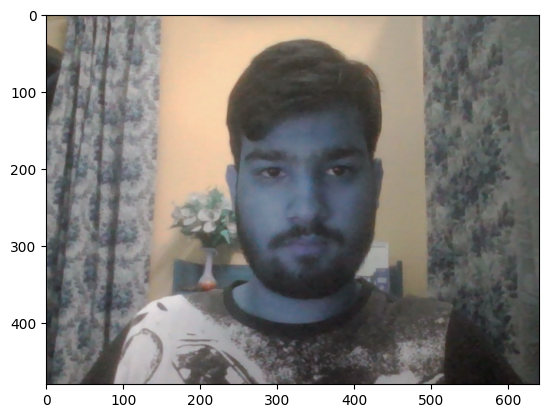

In [13]:
# this is the result from the abv code
plt.imshow(frame)


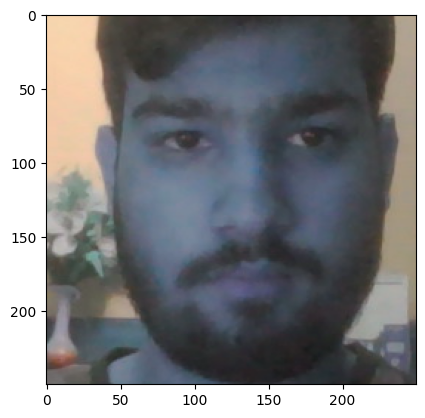

In [14]:
# the input frame size (not 250 x 250) which we need 
frame.shape # -> (480, 640, 3)

#applying slicing over the image to make it 250x250 (the training ds size)
frame[:250, :250 ,:].shape # -> (250, 250, 3)

# plt.imshow(frame[:250, :250 ,:]) # we will get the sliced top-right corner 
plt.imshow(frame[120:120+250,200:200+250 ,:]) # this will center up the slice roughly


# PreProcessing - Preparing data for deep learning

- ### Get image directories

In [15]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300) # extract everything frome the anchor repo, which has a .jpg extension
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)

In [16]:
dir_test = anchor.as_numpy_iterator()

In [17]:
dir_test.next()

b'data\\anchor\\b40ef98a-130f-11ee-9bc2-84a938bd3327.jpg'

- ### Preprocessing - Scale & Resize 

In [18]:
# loads our image, resize it for us 
def preprocess (file_path): 
    #load up the byte map of the image from the file_path - readin the image
    byte_img = tf.io.read_file(file_path)
    # decodes the image from the byte map 
    img = tf.io.decode_jpeg(byte_img)
    #resizing of the image (preprocessing )
    img = tf.image.resize(img, (100,100))
    # preforming the scalling over the image to be between (0,255) ( preprocessing )
    img = img / 255.0
    return img
# this function will return a numpy equvalent mappingof the image 

In [19]:
img = preprocess('data\\anchor\\86803bca-130f-11ee-955f-84a938bd3327.jpg')

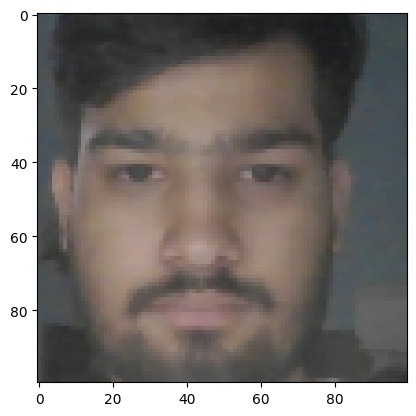

In [20]:
plt.imshow(img)


- ### creating a labelled dataset

In [21]:
# (anchor , positive) => 1,1,1,1,1,1
# (anchor , negative) => 0,0,0,0,0,0

In [22]:
# anchor_image ( the test image ) , postive_image , 1
positives = tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
# anchor_image ( the test image ) , negative_image , 0

negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [23]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [24]:
class_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))

In [25]:
samples = data.as_numpy_iterator()

In [26]:
eg = samples.next()
eg

(b'data\\anchor\\b247f1c5-130f-11ee-87fc-84a938bd3327.jpg',
 b'data\\positive\\130ffec8-1310-11ee-9201-84a938bd3327.jpg',
 1.0)

- ### Building Train & Train Partition

In [27]:
def preprocess_twin(input_img, validation_img, label ):
    return(preprocess(input_img), preprocess(validation_img), label)

In [28]:
res = preprocess_twin(*eg) # the star destructures the data

In [29]:
# building up dataloader pipeline -  tensorflow pipeline
# running twin data preprocessing over the entire ds
data = data.map(preprocess_twin)
# caching our images
data = data.cache()
#shuffling our images 
data = data.shuffle(buffer_size=1024)

0.0

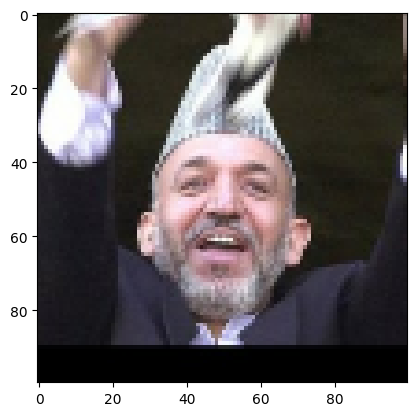

In [30]:
samples = data.as_numpy_iterator()
samp = samples.next()
plt.imshow(samp[1]) # negative / positive image 
samp[2] # labelled 0/1 


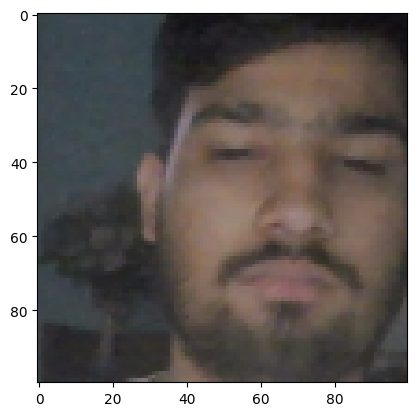

In [31]:
plt.imshow(samp[0]) # paired anchor image

In [32]:
# training & testing partition
# grabbing 70% of the data to train
train_data = data.take(round(len(data)*.7))
# dividing the data into batches of 16
train_data = train_data.batch(16)
# start preprocessing the next set of data over the NN, when we train 
train_data = train_data.prefetch(8)

In [33]:
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()
len(train_sample[0]) # there are 16 images in the set of each sample set

16

In [34]:
# testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [35]:
test_samples = test_data.as_numpy_iterator()
test_sample = test_samples.next()
len(test_sample[0]) # there are 16 images in the set of each sample set

16

## Building a Siamese NN

- ### Build an embedding layer

In [36]:
# this is like a data translator for our NN to verify up the user
# we will be doing convolution  + RelU + max-pooling over the functoin in the image matrix( initially from the input, then over the pooled down image)
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image') # we used keras (tf) here
    # FIRST LAYER 
    #convolution 
    c1 = Conv2D(64,(10,10),activation='relu')(inp)
    #max-pooling 
    m1 = MaxPooling2D(64,(2,2), padding='same')(c1)
    
    #SECOND LAYER
    c2 = Conv2D(128,(7,7),activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding='same')(c2)

    #THIRD LAYER
    c3 = Conv2D(128,(4,4),activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding='same')(c3)

    #FOURTH LAYER (FINAL EMBEDDED LAYER)
    c4 = Conv2D(256,(4,4),activation='relu')(m3)
    # fully connected layer with a sigmoid function (flatten + dense layer)
    f1= Flatten()(c4) # flattening the 3 dimensions, to 1 dimension
    d1= Dense(4096,activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')
    # this will return us the feture vector of 4096 units

In [37]:
inp = Input(shape=(100,100,3))
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_1')>

In [43]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [41]:
c1 = Conv2D(64,(10,10),activation='relu')(inp)
#max-pooling 
m1 = MaxPooling2D(64,(2,2), padding='same')(c1)

#SECOND LAYER
c2 = Conv2D(128,(7,7),activation='relu')(m1)
m2 = MaxPooling2D(64,(2,2), padding='same')(c2)
#THIRD LAYER
c3 = Conv2D(128,(4,4),activation='relu')(m2)
m3 = MaxPooling2D(64,(2,2), padding='same')(c3)
#FOURTH LAYER (FINAL EMBEDDED LAYER)
c4 = Conv2D(256,(4,4),activation='relu')(m3)
# fully connected layer with a sigmoid function (flatten + dense layer)
f1= Flatten()(c4) # flattening the 3 dimensions, to 1 dimension
d1= Dense(4096,activation='sigmoid')(f1)
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense_1')>

In [42]:
c1 = Conv2D(64,(10,10),activation='relu')(inp)
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d_8')>

In [39]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

- ### create an L1 Distance layer

In [44]:
# L1 distance layer - looks over how similar the images actually are
# will take up the above 4096 feature vector (the embedded model) & output a value 
class L1Dist(Layer):
    def __init__(self,**kwargs): 
        super().__init__() #inheritance
    
    # this is the logic here (the difference b/w the input_embedding and the validation_embedding)
    def call(self,input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [45]:

l1 = L1Dist()
l1

- ### compile the siamese Network/Model

In [46]:
# we make the final model over the embedding and followed by L1Dist, with activation at the end
def make_siamese_model(): 
    # handling the inputs 
    # anchor_image input
    input_img = Input(name='input_img', shape=(100, 100, 3))

    # validation_image input
    validation_img = Input(name='validation_img', shape=(100, 100, 3))

    # combining siamese distance components 
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_img), embedding(validation_img))

    # are those the same person (in the 2 images)
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_img, validation_img], outputs=classifier, name='SiameseNetwork')
    

In [47]:
input_image = Input(name='input_img',shape=(100,100,3))
validation_image = Input(name='validation_img',shape=(100,100,3))

embedding(input_image)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [48]:
embedding(validation_image)


<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [49]:
siamese_layer= L1Dist()
distances = siamese_layer(embedding(input_image), embedding(validation_image))
distances

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist_1')>

In [50]:
classif = Dense(1, activation='sigmoid')(distances)
classif 

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [51]:
model_fin = Model(inputs=[input_image,validation_image], outputs=[classif], name='SiameseNetwork')
model_fin.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [52]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

## Training a Siamese Neural Network

- ### setup a loss function & optimizer

In [53]:
#loss function
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [54]:
#optimizer (adam optimizer) 
opt = tf.keras.optimizers.Adam(1e-4) #0.001 -> Learning rate
# ref -> https://keras.io/api/optimizers/ 

- ### establish Checkpoints

In [55]:
#checkpoints for the model, in order if something breaks down we are able to track as to where the model broke off
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

- ### build Train Step Function

In [56]:
test_batch = train_data.as_numpy_iterator()
test_batch.next()

(array([[[[0.2120098 , 0.2747549 , 0.27083334],
          [0.20392157, 0.26568627, 0.26862746],
          [0.20857844, 0.2637255 , 0.27769607],
          ...,
          [0.07745098, 0.06960785, 0.07352941],
          [0.07745098, 0.06960785, 0.07352941],
          [0.07941177, 0.07156863, 0.0754902 ]],
 
         [[0.20686275, 0.26764706, 0.26911765],
          [0.21078432, 0.27009803, 0.27181372],
          [0.20465687, 0.25735295, 0.2620098 ],
          ...,
          [0.06960785, 0.06960785, 0.0632353 ],
          [0.06960785, 0.06960785, 0.06764706],
          [0.07083333, 0.07083333, 0.07083333]],
 
         [[0.20269608, 0.24779412, 0.27132353],
          [0.20833333, 0.25441176, 0.26715687],
          [0.21715686, 0.26102942, 0.27009803],
          ...,
          [0.06960785, 0.06666667, 0.05882353],
          [0.06960785, 0.06666667, 0.05882353],
          [0.07058824, 0.06470589, 0.06764706]],
 
         ...,
 
         [[0.3990196 , 0.3990196 , 0.4004902 ],
          [0.33259

In [57]:
batch_1 = test_batch.next()

In [58]:
X = batch_1[:2]
Y = batch_1[2]

In [59]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [60]:
Y

array([1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1.],
      dtype=float32)

In [61]:
#the actual training step for a single loop over the siamese, looped over by the next aspect
# one batch of data (inp_image(100,100,3), & validation_img & the validator -> res value (embed) each-> 4064 to classifier to 1)
# over the abv process we calculate our loss & apply backpropgation over the NN, and get the best possible model
# @tf.function # tf.funnction decorator (compiles a fuinction into a callable TF graph) - we are compiling whatever is happening under this
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [62]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
      floating-point value which either represents a
      [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
      when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
      `from_logits=False`).

    **Recommended Usage:** (set `from_logits=True`)

    With `tf.keras` API:

    ```python
    model.compile(
      loss=tf.keras.losses

- ### create a training Loop

In [63]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

- ### train the Model

In [64]:
EPOCHS = 50
train(train_data, EPOCHS)



 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 16s 334ms/step

 Epoch 2/50
27/27 [==============================] - 9s 334ms/step

 Epoch 3/50
27/27 [==============================] - 9s 326ms/step

 Epoch 4/50
27/27 [==============================] - 8s 309ms/step

 Epoch 5/50
27/27 [==============================] - 8s 312ms/step

 Epoch 6/50
27/27 [==============================] - 8s 321ms/step

 Epoch 7/50
27/27 [==============================] - 9s 331ms/step

 Epoch 8/50
27/27 [==============================] - 9s 342ms/step

 Epoch 9/50
27/27 [==============================] - 9s 337ms/step

 Epoch 10/50
27/27 [==============================] - 9s 341ms/step

 Epoch 11/50
27/27 [==============================] - 9s 339ms/step

 Epoch 12/50
27/27 [==============================] - 9s 328ms/step

 Epoch 13/50
27/27 [=====